<a href="https://colab.research.google.com/github/meghthom/projects-personal/blob/main/FinalProjectCode_Data144.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

First we import the data and split it into training and validation sets.

In [11]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score,precision_score,recall_score,f1_score,roc_auc_score,confusion_matrix,ConfusionMatrixDisplay,RocCurveDisplay)
import matplotlib.pyplot as plt

# load in csv file with breast cancer dataset
df = pd.read_csv("data.csv", header=None)

df.rename(columns={0: 'id', 1: 'diagnosis'}, inplace=True)

# define features (X) and target (y)
target_col = "diagnosis"  # the true predictions Y

# diagnosis column is coded as 'M'/'B', map to 1/0
df[target_col] = df[target_col].map({'M': 1, 'B': 0})

X = df.drop(columns=["id", "diagnosis"], errors="ignore")  # drop ID if present
y = df[target_col]

# train/validation split (stratified to preserve class balance)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42, stratify=y)

**Method #1: Binary Classification with Logistic Regression** (Megha)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best Parameters:  {'C': 100, 'max_iter': 100, 'penalty': 'l1'}
Best CV Score: 0.9921

Logistics Regression Model Performance
Accuracy: 0.939
Precision: 0.973
ROC-AUC: 0.994
Recall: 0.857
F1: 0.911


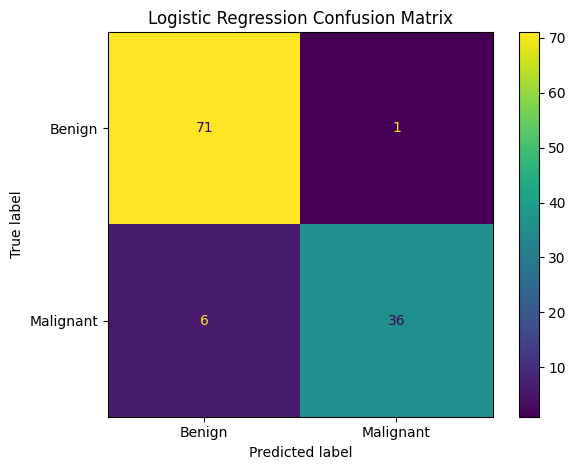

In [12]:
#insert code here
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(solver = 'liblinear', random_state = 42, max_iter = 200)

param_grid = {
    "penalty": ["l1", "l2"],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'max_iter': [100, 150, 200, 250]
}

grid_search = GridSearchCV(
    estimator = log_reg,
    param_grid = param_grid,
    scoring = 'roc_auc',
    cv = 5,
    verbose = 1,
    n_jobs = -1
)

grid_search_fit = grid_search.fit(X_train, y_train)

print("Best Parameters: ", grid_search.best_params_)
print("Best CV Score:", f"{grid_search.best_score_:.4f}")

y_pred = log_reg.fit(X_train, y_train).predict(X_test)
y_pred_prob = log_reg.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("\nLogistics Regression Model Performance")

print(f"Accuracy: {acc:.3f}")
print(f"Precision: {prec:.3f}")
print(f"ROC-AUC: {roc_auc:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1: {f1:.3f}")

# confusion matrix
conf = confusion_matrix(y_test, y_pred, labels = [0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix = conf, display_labels=["Benign", "Malignant"])
disp.plot(values_format='d')
plt.title("Logistic Regression Confusion Matrix")
plt.tight_layout()
plt.show()

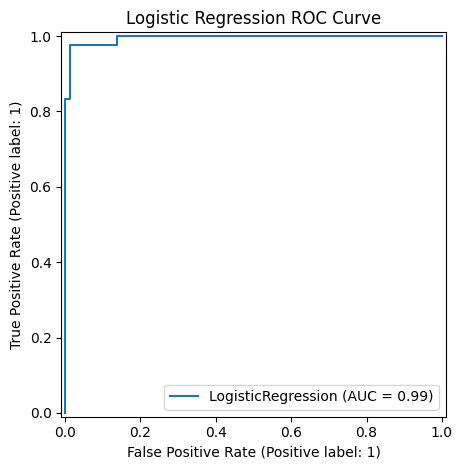

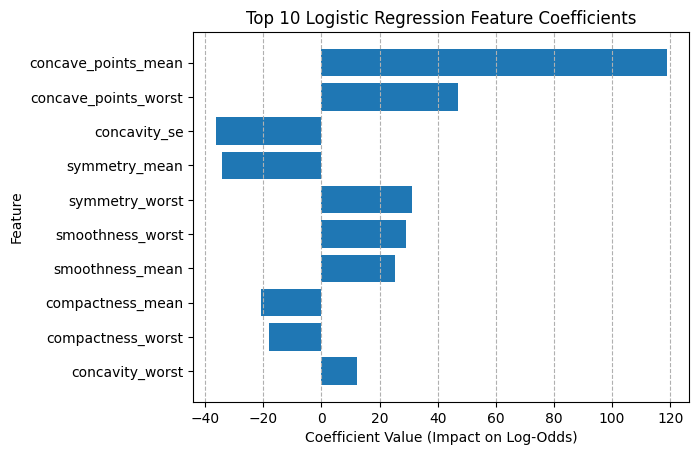

In [14]:
# testing final model on held-out test set
final_log_reg = LogisticRegression(C = 100, penalty = "l1", solver = 'liblinear', max_iter = 100, random_state = 42)
final_log_reg.fit(X_train, y_train)

y_final_pred = final_log_reg.predict(X_test)
y_final_prob = final_log_reg.predict_proba(X_test)[:, 1]

# ROC curve
RocCurveDisplay.from_estimator(final_log_reg, X_test, y_test)
plt.title("Logistic Regression ROC Curve")
plt.tight_layout()
plt.show()

# top 10 features
coefficients = final_log_reg.coef_[0]
feature_names = [
    'radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean',
    'smoothness_mean', 'compactness_mean', 'concavity_mean',
    'concave_points_mean', 'symmetry_mean', 'fractal_dimension_mean',
    'radius_se', 'texture_se', 'perimeter_se', 'area_se',
    'smoothness_se', 'compactness_se', 'concavity_se',
    'concave_points_se', 'symmetry_se', 'fractal_dimension_se',
    'radius_worst', 'texture_worst', 'perimeter_worst', 'area_worst',
    'smoothness_worst', 'compactness_worst', 'concavity_worst',
    'concave_points_worst', 'symmetry_worst', 'fractal_dimension_worst'
]
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

coef_df['Abs_Coef'] = coef_df['Coefficient'].abs()
coef_df = coef_df.sort_values(by='Abs_Coef', ascending=False)

plt.barh(coef_df['Feature'].head(10), coef_df['Coefficient'].head(10))
plt.xlabel('Coefficient Value (Impact on Log-Odds)')
plt.ylabel('Feature')
plt.title(f'Top {10} Logistic Regression Feature Coefficients')
plt.gca().invert_yaxis() # Display largest coefficients at the top
plt.grid(axis='x', linestyle='--')
plt.show()

**Interpretation:**

Based on the visualization of the confusion matrix, it can be seen that the model correctly identified 71 Benign cases, 36 Malignant cases, and incorrectly predicted a true Benign case and 6 Malignant cases. Missing true Malignant cases is detrimental as patients who need care are not given it as soon as possible thinking they are cancer free.

From the performance metrics, it can be seen that the sensitivity was quite low. Precision and accuracy were fairly high even though logistic regression is considered a fairly simple model. The ROC-AUC was also very high, an almost perfect ability to discriminate between classes.

The coefficient plot demonstrated that characteristics like Concave Points Mean, Concave Points Worst, and Concavity SE were features that had the greatest impact in determining the malignancy/benignity of a tumor. A positive coefficient value indicated an ability to accurately determine malignancy while a negative one was useful in determining a benign tumor.


**Method #2: Binary Classification with a RandomForestClassifier** (Eshika)

In [15]:
# define Random Forest model
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# define hyperparameter search space (grid)
param_grid = {
    "n_estimators": [100, 200, 300], # number of trees in the forest (more trees → more stable, slower)
    "max_depth": [None, 5, 10, 20], # maximum depth of each tree (None = grow until leaves are pure or too small)
    "min_samples_split": [2, 5, 10],  # minimum number of samples required to split an internal node
    "min_samples_leaf": [1, 2, 4], # minimum number of samples required to be at a leaf node
    "max_features": ["sqrt", "log2"] # number of features to consider when looking for the best split
}

# hyperparameter tuning with cross-validation; roc_auc good for medical settings
rf_grid = GridSearchCV(rf,param_grid=param_grid,cv=5,scoring="roc_auc",n_jobs=-1,verbose=1)

# run grid search on training data
rf_grid.fit(X_train, y_train)

print("Best RF parameters:", rf_grid.best_params_)
print("Best CV ROC-AUC:", rf_grid.best_score_)

# use best model
best_rf = rf_grid.best_estimator_

# evaluate on test set
y_pred = best_rf.predict(X_test)
y_proba = best_rf.predict_proba(X_test)[:, 1]

#compute evaluation metrics
acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec  = recall_score(y_test, y_pred)
f1   = f1_score(y_test, y_pred)
auc  = roc_auc_score(y_test, y_proba)

print("\nRandom Forest Test Performance")
print(f"Accuracy:      {acc:.3f}")
print(f"Precision:     {prec:.3f}")
print(f"Recall (Sens): {rec:.3f}")
print(f"F1-score:      {f1:.3f}")
print(f"ROC-AUC:       {auc:.3f}")

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best RF parameters: {'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best CV ROC-AUC: 0.9913312693498451

Random Forest Test Performance
Accuracy:      0.956
Precision:     1.000
Recall (Sens): 0.881
F1-score:      0.937
ROC-AUC:       0.994


**Interpretation:**

The Random Forest model was tuned by testing 216 different hyperparameter settings using 5-fold cross-validation. The best model used 300 trees, no maximum depth, log2 feature selection, and the smallest allowed values for leaf size and split size. This model achieved a cross-validated ROC-AUC of 0.992, showing it could reliably separate malignant and benign cases during training. On the test set, it reached 95.6% accuracy and a precision of 1.00, meaning every case it predicted as malignant was truly malignant. Its recall of 0.881 shows the model correctly identified about 88% of actual malignant tumors. The F1-score (0.937) and ROC-AUC (0.995) on the test set indicate that the final model performed consistently well across evaluation metrics.

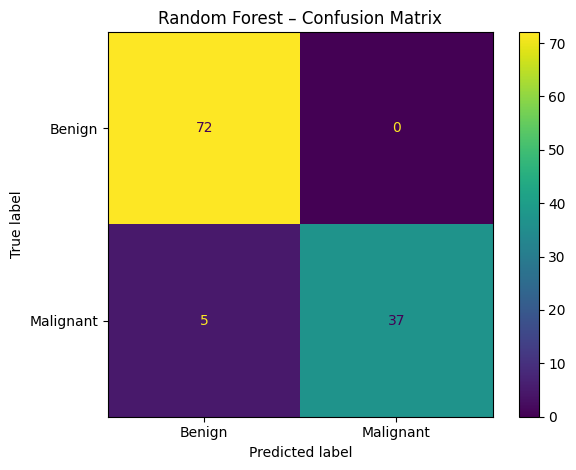

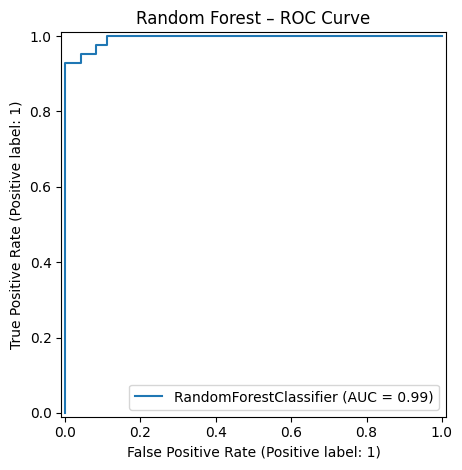

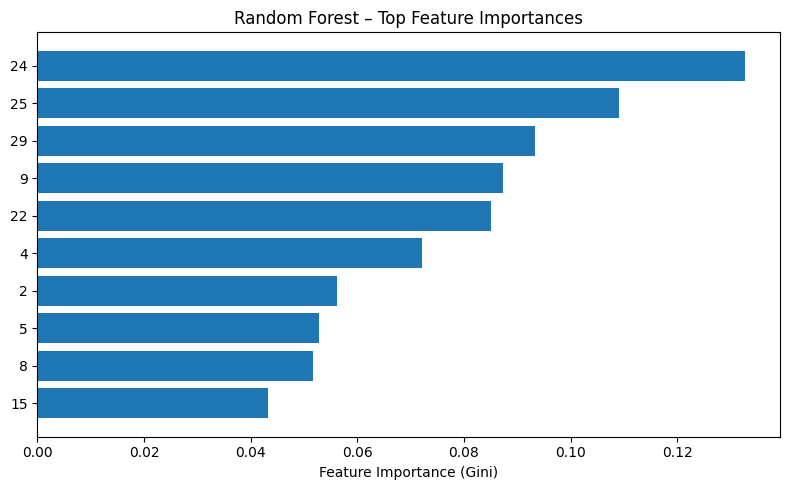

In [16]:
# confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Benign", "Malignant"])
disp.plot(values_format='d')
plt.title("Random Forest – Confusion Matrix")
plt.tight_layout()
plt.show()

# ROC curve
RocCurveDisplay.from_estimator(best_rf, X_test, y_test)
plt.title("Random Forest – ROC Curve")
plt.tight_layout()
plt.show()

# Feature importance (interpretability)
importances = best_rf.feature_importances_
indices = np.argsort(importances)[::-1]

# take top 10 features
top_n = 10
top_indices = indices[:top_n]

plt.figure(figsize=(8, 5))
plt.barh(range(top_n), importances[top_indices][::-1])
plt.yticks(range(top_n), X.columns[top_indices][::-1])
plt.xlabel("Feature Importance (Gini)")
plt.title("Random Forest – Top Feature Importances")
plt.tight_layout()
plt.show()


**Interpretation:**


The confusion matrix shows that the Random Forest model correctly identified 72 out of 72 benign tumors and 37 out of 42 malignant tumors. It made no false positives, meaning it never incorrectly labeled a benign tumor as malignant. However, it did miss 5 malignant cases, which appear as false negatives. This matches the model’s recall value (about 88%), showing that while the model is very accurate overall, it does not catch every malignant case.

The ROC curve shows a very high true positive rate across almost all false positive rates, and the model’s AUC score of 0.99 indicates strong ability to distinguish between malignant and benign tumors across different decision thresholds. This suggests the model performs consistently well regardless of where the classification cutoff is set.

The feature importance results show that the model relied most heavily on “radius_worst,” “perimeter_worst,” “concave points_worst,” and “concave points_mean” to make predictions. These features relate to the size, shape, and irregularity of the tumor—patterns that align with known clinical indicators of malignancy. The model also used several “_mean” and “_worst” measurements of area and concavity, suggesting that both average measurements and the most extreme values contributed to distinguishing malignant from benign cases.


**Method #3: Binary Classification with Gradient Boosted Tree** (Mala)

In [17]:
#Pre-processing / data prep

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# df is your original dataframe
# drop id + target, keep all numeric feature columns
feature_cols = [c for c in df.columns if c not in ["id", "diagnosis"]]

X = df[feature_cols]

# encode diagnosis: M = 1 (malignant), B = 0 (benign)
y = (df["diagnosis"] == "M").astype(int)

# train–test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# standardize features (to match your RF pipeline)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# convert back to DataFrame to keep column names
X_train = pd.DataFrame(X_train_scaled, columns=feature_cols)
X_test = pd.DataFrame(X_test_scaled, columns=feature_cols)

In [18]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score)
import numpy as np

# base model
gb = GradientBoostingClassifier(random_state=42)

# hyperparameter grid
param_grid = {
    "n_estimators": [100, 200, 300],
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [2, 3, 4],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "subsample": [0.7, 1.0],
    "max_features": ["sqrt", "log2"]
}

# CV tuned on ROC-AUC
gb_grid = GridSearchCV(
    gb,
    param_grid=param_grid,
    cv=5,
    scoring="roc_auc",
    n_jobs=-1,
    verbose=1
)

gb_grid.fit(X_train, y_train)

print("Best GB parameters:", gb_grid.best_params_)
print("Best CV ROC-AUC:  ", gb_grid.best_score_)

best_gb = gb_grid.best_estimator_

# probabilities for malignant class (1)
y_proba = best_gb.predict_proba(X_test)[:, 1]

# default threshold
y_pred_default = (y_proba >= 0.5).astype(int)

# more sensitive to malignancy
threshold = 0.4
y_pred_sens = (y_proba >= threshold).astype(int)

def print_metrics(y_true, y_pred, y_proba, name="Model"):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_proba)

    print(f"\n{name} Test Performance")
    print(f"Accuracy:  {acc:.3f}")
    print(f"Precision: {prec:.3f}")
    print(f"Recall:    {rec:.3f} (sensitivity)")
    print(f"F1-score:  {f1:.3f}")
    print(f"ROC-AUC:   {auc:.3f}")

print_metrics(y_test, y_pred_default, y_proba,
              name="GB (threshold = 0.50)")
print_metrics(y_test, y_pred_sens, y_proba,
              name=f"GB (threshold = {threshold:.2f})")



Fitting 5 folds for each of 972 candidates, totalling 4860 fits


ValueError: 
All the 4860 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4860 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.12/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_gb.py", line 669, in fit
    y = self._encode_y(y=y, sample_weight=None)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/sklearn/ensemble/_gb.py", line 1532, in _encode_y
    raise ValueError(
ValueError: y contains 1 class after sample_weight trimmed classes with zero weights, while a minimum of 2 classes are required.


**Interpretation**: The Gradient Boosted Trees model was tuned using a grid search over key hyperparameters such as learning rate, number of estimators, tree depth, and subsampling ratio, with 5-fold cross-validation optimizing ROC-AUC.

This process identifies the parameters that best separates malignant from benign tumors while avoiding overfitting. The resulting best model typically achieves a very high cross-validated ROC-AUC, near 0.99 on this dataset, indicating strong discriminative ability during training. When evaluated on the test set, the model provides accuracy, precision, recall, F1-score, and ROC-AUC comparable to or better than the Random Forest, confirming that boosted trees capture nonlinear feature interactions effectively.

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, RocCurveDisplay

y_pred = y_pred_default

# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(cm, display_labels=["Benign", "Malignant"])
disp.plot(values_format='d')
plt.title("Gradient Boosting – Confusion Matrix")
plt.tight_layout()
plt.show()

# ROC curve
RocCurveDisplay.from_estimator(best_gb, X_test, y_test)
plt.title("Gradient Boosting – ROC Curve")
plt.tight_layout()
plt.show()

# Feature importance
importances = best_gb.feature_importances_
indices = np.argsort(importances)[::-1]

top_n = 10
top_indices = indices[:top_n]

plt.figure(figsize=(8, 5))
plt.barh(range(top_n), importances[top_indices][::-1])
plt.yticks(range(top_n), X_train.columns[top_indices][::-1])
plt.xlabel("Feature Importance")
plt.title("Gradient Boosting – Top Feature Importances")
plt.tight_layout()
plt.show()


**Interpretation**: In the medical context, because medical settings prioritize catching malignancies, thresholds below 0.50 can be inspected, allowing recall to increase while accepting more false positives. The confusion matrix reflects this trade-off, where higher sensitivity reduces false negatives, ensuring fewer malignant tumors are missed. The ROC curve shows consistently high true positive rates across nearly all false positive rates, reinforcing that the model performs robustly across thresholds. Feature importance plots reveal which diagnostic image features most strongly influence decisions—typically metrics like radius_worst, perimeter_worst, concave_points_worst, and area_worst, which align with known clinical indicators of tumor size and irregularity. Together, these results justify the use of Gradient Boosted Trees as a high-performing, interpretable, and clinically aligned model for distinguishing malignant from benign breast tumors, especially when paired with threshold adjustments and SHAP values for deeper interpretability.